In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'league-of-legends:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2361%2F4394%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T114151Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D07f00864909a76c9f15eee5619a9ffdac416171d3f29557d17198d0aa80a5117478f4e9c806f9b2f2158d50c89515012750fe55f4fd38740c084fc84ee56930d77277b338382b2f6844ea1b1ac49544ea51d4394b60358fafd59ed0beee100b58b57322d7fe67ed8adb51d418909f8bfb9b890b31ac8761f28496f4be8c5fff3b9d6d21a04b40599cdd13ce7451872111c65ae6770c39534c8c93335ea3f0232db6f78656ad250cb909437f0bf6cffc1a47f8d89b38830273f8539f0572d125b49624c0c3e493d40e9c08053c2739b315876ad9e776e3ee6d328bc9642bb7c7f66dd5f27ca75e24b183dac0e7d683ed8a8af79b65fc5ce7a5c4590558e314397'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 3136041 bytes downloaded
Downloaded and uncompressed: league-of-legends
Data source import complete.


## Introduction:
<font color = "green">
    Content:
    
1. [Getting the data](#1)
1. [Checking the data](#2)
1. [Finding Corrolations](#3)
1. [Checking for Missing Values](#4)    
1. [Visualization](#5)   
1. [Machine Learning](#6)
    * [Supervised Learning](#7)   
        * [Linear Regression](#7)
        * [The logic Behind the Logistic Regression](#8)
        * [Logistic Regression](#9)
        * [K-Nearest Neighbors (KNN)](#10)
        * [Support Vector Machine (SVM)](#11)
        * [Naive Bayes](#12)
        * [Decision Tree](#13)
        * [Random Forest](#14)
    * [Unsupervised Learning](#15)
        * [Kmeans Clustering](#16)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/league-of-legends/games.csv
/kaggle/input/league-of-legends/champion_info.json
/kaggle/input/league-of-legends/champion_info_2.json
/kaggle/input/league-of-legends/summoner_spell_info.json


<a id = "1"></a>
# GETTING THE DATA

In [ ]:

data_champ = pd.read_json("../input/league-of-legends/champion_info.json")

In [ ]:
data_champ2 = pd.read_json("../input/league-of-legends/champion_info_2.json")

In [ ]:
champInfo = pd.read_json((data_champ2['data']).to_json(), orient='index') #Datayi bir sozluk olarak alip her bir anahtara karsilik bir column ekliyor

In [ ]:
champInfo2 = pd.read_json((data_champ["data"]).to_json(),orient = "index")

In [ ]:
data_spell = pd.read_json("/kaggle/input/league-of-legends/summoner_spell_info.json")

In [ ]:
data_spell_info = pd.read_json((data_spell['data']).to_json(), orient='index')

In [ ]:
data_game = pd.read_csv("/kaggle/input/league-of-legends/games.csv")

In [ ]:
data_game2 = pd.read_csv("/kaggle/input/league-of-legends/games.csv")

In [ ]:
winner = data_game2[["winner"]]

In [ ]:
winner = winner.T
winner.shape

(1, 51490)

In [ ]:
name_dict = pd.Series(champInfo.key.values,index=champInfo.id).to_dict()

<a id = "2"></a>
# Looking at the data

In [ ]:
for keys,values in name_dict.items():
    print(keys,values)

-1 None
62 MonkeyKing
24 Jax
9 Fiddlesticks
35 Shaco
19 Warwick
498 Xayah
76 Nidalee
143 Zyra
240 Kled
63 Brand
33 Rammus
420 Illaoi
42 Corki
201 Braum
122 Darius
23 Tryndamere
21 MissFortune
83 Yorick
101 Xerath
15 Sivir
92 Riven
61 Orianna
41 Gangplank
54 Malphite
78 Poppy
30 Karthus
126 Jayce
20 Nunu
48 Trundle
104 Graves
25 Morgana
150 Gnar
99 Lux
102 Shyvana
58 Renekton
114 Fiora
222 Jinx
429 Kalista
105 Fizz
38 Kassadin
37 Sona
39 Irelia
112 Viktor
497 Rakan
203 Kindred
69 Cassiopeia
57 Maokai
516 Ornn
412 Thresh
10 Kayle
120 Hecarim
121 Khazix
2 Olaf
115 Ziggs
134 Syndra
36 DrMundo
43 Karma
1 Annie
84 Akali
106 Volibear
157 Yasuo
85 Kennen
107 Rengar
13 Ryze
98 Shen
154 Zac
91 Talon
50 Swain
432 Bard
14 Sion
67 Vayne
75 Nasus
141 Kayn
4 TwistedFate
31 Chogath
77 Udyr
236 Lucian
427 Ivern
89 Leona
51 Caitlyn
113 Sejuani
56 Nocturne
26 Zilean
268 Azir
68 Rumble
163 Taliyah
17 Teemo
6 Urgot
32 Amumu
3 Galio
74 Heimerdinger
34 Anivia
22 Ashe
161 Velkoz
27 Singed
72 Skarner
110 Varus

In [ ]:
champInfo

,tags,title,id,key,name
None,[],None,-1,None,None
MonkeyKing,"[Fighter, Tank]",the Monkey King,62,MonkeyKing,Wukong
Jax,"[Fighter, Assassin]",Grandmaster at Arms,24,Jax,Jax
Fiddlesticks,"[Mage, Support]",the Harbinger of Doom,9,Fiddlesticks,Fiddlesticks
Shaco,[Assassin],the Demon Jester,35,Shaco,Shaco
...,...,...,...,...,...
KogMaw,"[Marksman, Mage]",the Mouth of the Abyss,96,KogMaw,Kog'Maw
Ahri,"[Mage, Assassin]",the Nine-Tailed Fox,103,Ahri,Ahri
Quinn,"[Marksman, Fighter]",Demacia's Wings,133,Quinn,Quinn
Leblanc,"[Assassin, Mage]",the Deceiver,7,Leblanc,LeBlanc


In [ ]:
champInfo2

,title,id,key,name
1,the Dark Child,1,Annie,Annie
2,the Berserker,2,Olaf,Olaf
3,the Colossus,3,Galio,Galio
4,the Card Master,4,TwistedFate,Twisted Fate
5,the Seneschal of Demacia,5,XinZhao,Xin Zhao
...,...,...,...,...
429,the Spear of Vengeance,429,Kalista,Kalista
432,the Wandering Caretaker,432,Bard,Bard
497,The Charmer,497,Rakan,Rakan
498,the Rebel,498,Xayah,Xayah


In [ ]:
data_game

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,3308904636,1503076540231,1944,9,2,1,2,2,0,2,...,10,2,0,4,0,55,-1,90,238,157
51486,3215685759,1496957179355,3304,9,2,1,1,2,2,2,...,11,7,4,4,1,157,55,119,154,105
51487,3322765040,1504029863961,2156,9,2,2,2,2,0,1,...,10,2,0,2,0,113,122,53,11,157
51488,3256675373,1499562036246,1475,9,2,2,2,2,0,2,...,11,3,0,1,0,154,39,51,90,114


### PREPARE THE DATA

In [ ]:
data_game.drop(["gameId"],axis = 1,inplace = True)

In [ ]:
data_game.drop(["creationTime"],axis = 1,inplace = True)

In [ ]:
champs = data_game[["t1_champ1id","t1_champ2id",
                      "t1_champ3id","t1_champ4id","t1_champ5id","t2_champ1id",
                      "t2_champ2id","t2_champ3id","t2_champ4id","t2_champ5id","t1_ban1","t1_ban2","t1_ban3",
                      "t1_ban4","t1_ban5","t2_ban1","t2_ban2","t2_ban3","t2_ban4","t2_ban5"]]

In [ ]:
data_game.drop(["t1_champ1id","t1_champ2id",
                      "t1_champ3id","t1_champ4id","t1_champ5id","t2_champ1id",
                      "t2_champ2id","t2_champ3id","t2_champ4id","t2_champ5id","t1_ban1","t1_ban2","t1_ban3",
                      "t1_ban4","t1_ban5","t2_ban1","t2_ban2","t2_ban3","t2_ban4","t2_ban5","gameDuration","seasonId"],axis = 1,inplace = True)

In [ ]:
data_game["t1_total_kills"] = data_game["t1_champ1_sum1"] + data_game["t1_champ1_sum2"] + data_game["t1_champ2_sum1"] + data_game["t1_champ2_sum2"] + data_game["t1_champ3_sum1"] + data_game["t1_champ3_sum2"] + data_game["t1_champ4_sum1"] + data_game["t1_champ4_sum2"] + data_game["t1_champ5_sum1"] + data_game["t1_champ5_sum2"]
data_game["t2_total_kills"] = data_game["t2_champ1_sum1"] + data_game["t2_champ1_sum2"] + data_game["t2_champ2_sum1"] + data_game["t2_champ2_sum2"] + data_game["t2_champ3_sum1"] + data_game["t2_champ3_sum2"] + data_game["t2_champ4_sum1"] + data_game["t2_champ4_sum2"] + data_game["t2_champ5_sum1"] + data_game["t2_champ5_sum2"]




In [ ]:
data_game[["t1_total_kills","t2_total_kills","winner"]]

,t1_total_kills,t2_total_kills,winner
0,69,61,1
1,67,78,1
2,65,71,1
3,65,69,1
4,60,65,1
...,...,...,...
51485,78,65,2
51486,78,67,2
51487,65,76,2
51488,67,76,2


<a id = "3"></a>
# Finding Corrolations
## Basic Data Analysis
### Corrolations:
* firstInhibitor to winner
* firstBaron to winner
* firstTower to winner


In [ ]:
# firstInhibitor vs winner
data_game[["firstInhibitor","winner"]].groupby(["firstInhibitor"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstInhibitor,winner
2,2,1.913448
0,0,1.488528
1,1,1.091307


### First inhibitor has a huge effect on defining the winner!

In [ ]:
# firstBaron vs winner
data_game[["firstBaron","winner"]].groupby(["firstBaron"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstBaron,winner
2,2,1.802416
0,0,1.464705
1,1,1.188372


### First Baron also has a huge impact on determining the winner!

In [ ]:
# firstTower vs winner
data_game[["firstTower","winner"]].groupby(["firstTower"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstTower,winner
2,2,1.708019
0,0,1.482275
1,1,1.291597


### First tower has also big impact but less than the FirstBaron and FirstInhibitor.

## Lets look at lower corrolations:
* firstBlood to winner
* firstDragon to winner
* firstRiftHerald to winner

In [ ]:
# firstBlood vs winner
data_game[["firstBlood","winner"]].groupby(["firstBlood"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstBlood,winner
2,2,1.587181
0,0,1.463063
1,1,1.405200


In [ ]:
# firstDragon vs winner
data_game[["firstDragon","winner"]].groupby(["firstDragon"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstDragon,winner
2,2,1.674677
0,0,1.464000
1,1,1.314014


In [ ]:
# firstDragon vs winner
data_game[["firstRiftHerald","winner"]].groupby(["firstRiftHerald"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstRiftHerald,winner
2,2,1.694653
0,0,1.491615
1,1,1.305453


### Not surprisingly these three have positive corrolations with determining the winner.

## ***So, by looking at this data, lets try to see the posibility for total when all the constraints above are satisfied*.**

In [ ]:
data_game[data_game["winner"] == 2] #Look at the number of rows to see how many times number 2 won. Which is 25413.

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1_sum1,t1_champ1_sum2,t1_champ2_sum1,...,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t1_total_kills,t2_total_kills
8,2,2,2,2,0,2,2,12,4,4,...,11,14,4,8,1,0,2,1,56,85
9,2,2,2,2,2,2,0,4,3,11,...,4,12,4,8,3,1,2,0,67,67
10,2,2,2,2,2,2,2,4,21,7,...,4,3,4,10,2,1,1,1,74,67
14,2,2,2,1,1,2,0,4,3,4,...,12,4,7,9,2,0,2,0,69,67
16,2,2,2,2,2,2,0,4,7,3,...,3,4,12,9,3,2,4,0,74,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51484,2,2,1,2,2,2,0,4,7,7,...,14,4,12,11,5,2,3,0,83,69
51485,2,1,2,2,0,2,0,12,4,4,...,4,11,4,10,2,0,4,0,78,65
51486,2,1,1,2,2,2,2,4,14,4,...,12,14,4,11,7,4,4,1,78,67
51487,2,2,2,2,0,1,0,11,4,7,...,4,14,4,10,2,0,2,0,65,76


In [ ]:
constraints = (data_game["firstInhibitor"] == 2) & (data_game["firstBaron"] == 2) & (data_game["firstTower"] == 2) & (data_game["firstRiftHerald"] == 2) & (data_game["firstBlood"] == 2) & (data_game["firstDragon"] == 2)

In [ ]:
data_game[constraints & (data_game["winner"] == 2)]

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1_sum1,t1_champ1_sum2,t1_champ2_sum1,...,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t1_total_kills,t2_total_kills
10,2,2,2,2,2,2,2,4,21,7,...,4,3,4,10,2,1,1,1,74,67
52,2,2,2,2,2,2,2,21,4,14,...,4,14,4,7,1,1,2,1,85,70
56,2,2,2,2,2,2,2,12,4,4,...,6,4,12,9,1,1,2,1,69,67
62,2,2,2,2,2,2,2,11,4,4,...,4,7,4,10,3,1,3,1,67,74
83,2,2,2,2,2,2,2,12,4,4,...,7,12,4,8,2,1,3,1,67,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51207,2,2,2,2,2,2,2,7,4,4,...,12,4,14,10,2,2,3,1,61,67
51266,2,2,2,2,2,2,2,7,4,21,...,7,4,12,11,3,1,4,1,74,76
51326,2,2,2,2,2,2,2,6,4,4,...,3,11,4,10,2,1,1,1,59,59
51346,2,2,2,2,2,2,2,4,7,14,...,4,14,4,11,2,2,4,1,70,67


In [ ]:
1648/1734*100/100

0.95040369088812

So, we conclude that, if all of these constraints are satisfied, the probability of winning is 95 percent!

<a id = "4"></a>
# CHECKING FOR MISSING VALUES

In [ ]:
data_game.columns[data_game.isnull().any()]

Index([], dtype='object')

In [ ]:
data_game.isnull().sum()

,0
winner,0
firstBlood,0
firstTower,0
firstInhibitor,0
firstBaron,0
firstDragon,0
firstRiftHerald,0
t1_champ1_sum1,0
t1_champ1_sum2,0
t1_champ2_sum1,0


### We have found that there is no null information in our data.

<a id = "5"></a>
# VISUALIZATION

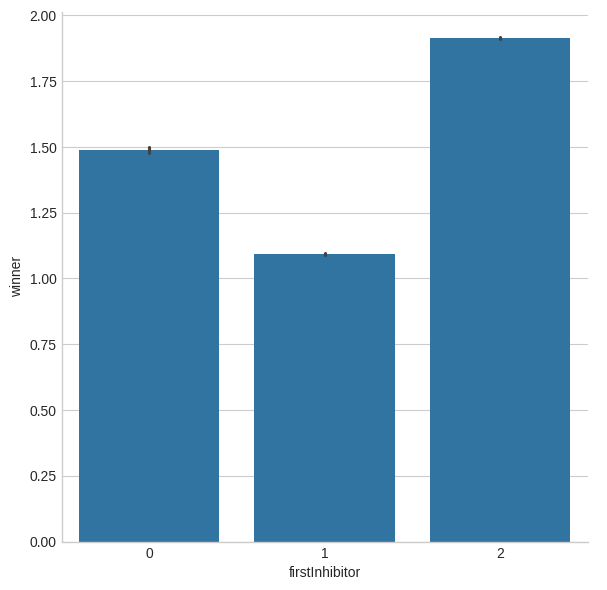

In [ ]:
g = sns.catplot(x="firstInhibitor", y="winner", data=data_game, kind="bar", height=6)


## We can observe the direct influence of firstInhibitor on determining the winner.

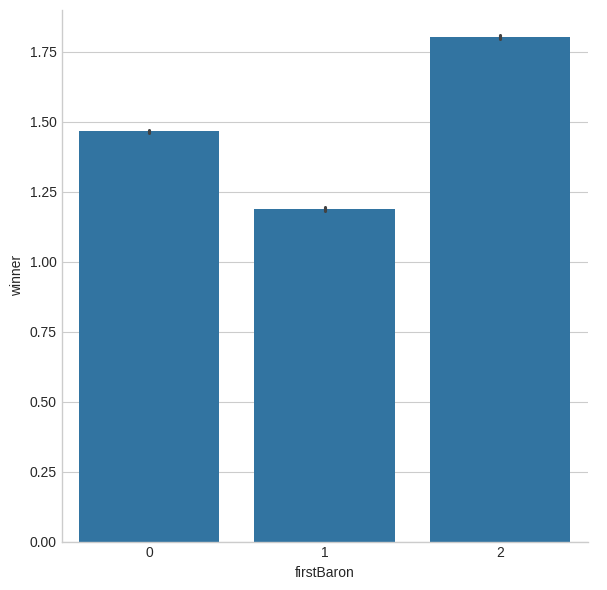

In [ ]:
g = sns.catplot(x = "firstBaron",y = "winner", data = data_game,kind = "bar",height = 6)

## The results are basically same as the firstInhibitor. We could argue that, if a team get the first baron, they are more likely to win the game!

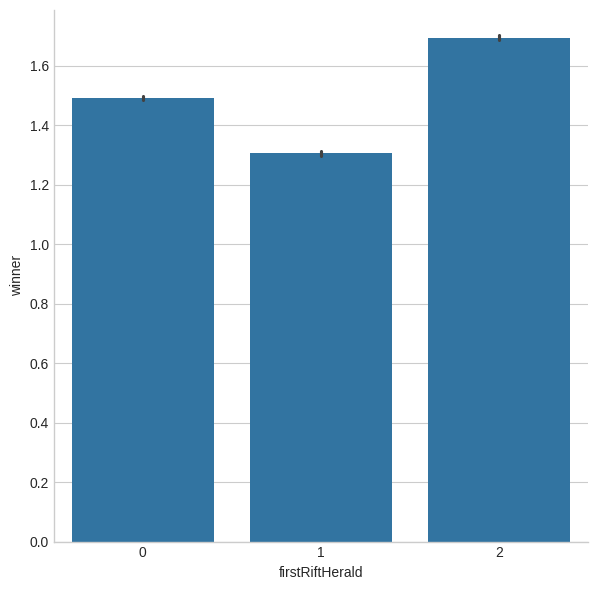

In [ ]:
g = sns.catplot(x = "firstRiftHerald",y = "winner", data = data_game,kind = "bar",height = 6)

## Even though it the rate is lower than the previous ones, we could still observe a direct relationship between the first riftherald and the chance of being winner!

## Lets look at them as a heatmap!

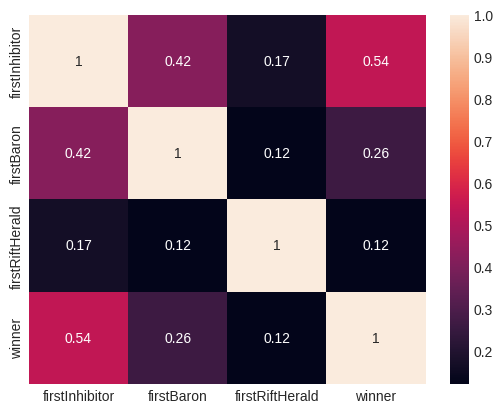

In [ ]:
sns.heatmap(data_game[["firstInhibitor","firstBaron","firstRiftHerald","winner"]].corr(),annot = True)
plt.show()

<a id = "6"></a>
# MACHINE LEARNING

<a id = "7"></a>
# SUPERVISED LEARNING

### Making data_game ready for our machine learning process.

In [ ]:
data_game.head()

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1_sum1,t1_champ1_sum2,t1_champ2_sum1,...,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t1_total_kills,t2_total_kills
0,1,2,1,1,1,1,2,12,4,3,...,4,4,3,5,0,0,1,1,69,61
1,1,1,1,1,0,1,1,7,4,12,...,14,4,7,2,0,0,0,0,67,78
2,1,2,1,1,1,2,0,4,7,11,...,11,7,4,2,0,0,1,0,65,71
3,1,1,1,1,1,1,0,4,12,4,...,14,4,7,0,0,0,0,0,65,69
4,1,2,1,1,1,1,0,4,12,11,...,12,4,7,3,0,0,1,0,60,65


> Lets create our X and Y

In [ ]:
x_data = data_game.T.drop(["winner"],axis = 0)
y = data_game["winner"].values

In [ ]:
# Normalization
x = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [ ]:
x = x.T

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)


<a id = "8"></a>
## LETS TRY TO UNDERSTAND THE LOGIC:

In [ ]:
#Initialize weights and bias

def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w,b

#Lets find the sigmoid(z)
def sigmoid(z):
    y_head = 1/(1 + np.exp(-z))
    return y_head


#Forward and backward propagation
def forward_backward_pro(w,b,game_train,y_train):
    #Forward propagation
    z = np.dot(w.T,game_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/game_train.shape[1] #game_train.shape[1] (which is 36 in this case) for scaling
    
    #Backward propagation
    derivative_weight = (np.dot(game_train,((y_head-y_train).T)))/game_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/game_train.shape[1]
    gradients = {"derivative_weight":derivative_weight,"derivative_bias":derivative_bias}
    
    return cost,gradients
    

#Lets update (learn) the parameters
def update(w,b,game_train,y_train,learning_rate,number_of_iteration):
    cost_list = []
    cost_list2 = []
    index = []
    
    # updating parameters number of iteration times
    for i in range(number_of_iteration):
        # do the back and forward propagation to find the cost and gradients
        cost,gradients = forward_backward_pro(w,b,game_train,y_train)
        cost_list.append(cost)
        #lets update
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 10 == 0:
            cost_list2.append(i)
            index.append(i)
            print("Cost after iteration %i: %f"%(i,cost))
            
    # we update parameters weights and bias
    parameters = {"weight":w,"bias":b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation ="vertical")
    plt.xlabel("Number of iteration")
    plt.ylabel("Cost")
    plt.show()
    return parameters,gradients,cost_list

#Lets predict
def predict(w,b,game_test):
    # game_test is the input for the forward prop
    z = sigmoid(np.dot(w,game_test) + b ) #Why w.T ?
    Y_prediction = np.zeros((1,x_test.shape[1])) # which is 36 np.zeros((1,x_test.shape[1]))
    # if z is bigger than 0.5, our prediction is sign one (y_head=1), ??
    # if z is smaller than 0.5, our prediction is sign zero (y_head=0), ??
    for i in range(z.shape[1]):
        if z[0,i] <= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
            
    return Y_prediction                    

### Lets do the logistic regression
def logistic_regression(game_train,y_train,data_test,y_test,learning_rate,num_iterations):
    #Initialize
    dimension = game_train.shape[0] #Which is 36
    w,b = initialize_weights_and_bias(dimension)
    #Do not change the learning rate
    parameters,gradients,cost_list = update(w,b,game_train,y_train,learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],game_test)
    
    # Print test errors
    print("test accuracy: {}%".format(100 - np.mean(np.abs(y_prediction_test - y_test))* 100))
    
  

### Those located above are to understand the logic behind the scenes!

<a id = "9"></a>
## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)
print("test accuracy {}".format(lr.score(x_test,y_test)))

test accuracy 0.9580501068168576


### By using Logistic Regression method, we have predicted the winner and the accuracy rate for that is 96% according to LR score.

<a id = "10"></a>
## K-NEAREST NEIGHBORS (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
#print("Prediction: {}".format(prediction))


### Since the number of items in the list are too many, the code above is not working. Thats why we can look at the first 20 estimations that our model made and compare them with the actual ones.

In [ ]:
print(prediction[:20])
print(y_test[:20])

[2 1 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 2 2 1]
[1 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 1 2 2 2]


### A better way to see the accuracy is to check the score!

In [ ]:
print("Accuracy {}".format(knn.score(x_test,y_test)))

Accuracy 0.9000776849873762


### Here we observe a 91.5% of accuracy for our KNN model.

<a id = "11"></a>
## SUPPORT VECTOR MACHINE (SVM)

In [ ]:
from sklearn.svm import SVC

svm = SVC(random_state = 1)
svm.fit(x_train,y_train)

print("print accuracy of svm algo: ",svm.score(x_test,y_test))

NameError: name 'x_train' is not defined

### With this method we got 96.1% Accuracy rate.

<a id = "12"></a>
## NAIVE BAYES

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)
print("Accuracy: ",nb.score(x_test,y_test))

Accuracy:  0.9400854534861138


### With this method we got 93.6% Accuracy rate.

<a id = "13"></a>
## DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
print("Accuracy: {}".format(dt.score(x_test,y_test)))

Accuracy: 0.9607690813750243


### With this method we got 95.7% Accuracy rate.

<a id = "14"></a>
## RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
print("Accuracy: {}".format(rf.score(x_test,y_test)))

Accuracy: 0.9687317925810837


### With this method we got 97% Accuracy rate!

### * Lets create a confusion matrix.

In [ ]:
y_pred = rf.predict(x_test)
y_true = y_test
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)

### Lets visualize it

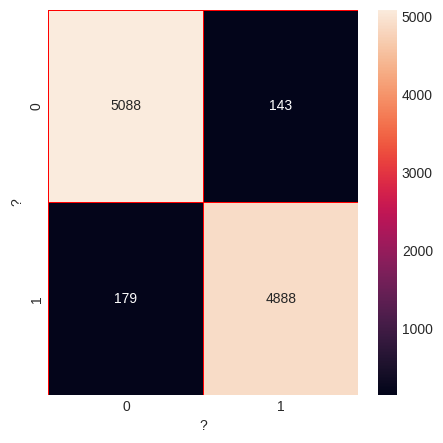

In [ ]:
import seaborn as sns
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot = True,linewidth = 0.5,linecolor = "red",fmt = ".0f",ax=ax)
plt.xlabel("?")
plt.ylabel("?")
plt.show()

<a id = "15"></a>
# UNSUPERVISED LEARNING

<a id = "16"></a>
## Kmeans Clustering

In [ ]:
x.head()

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1_sum1,t1_champ1_sum2,t1_champ2_sum1,t1_champ2_sum2,...,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t1_total_kills,t2_total_kills
0,0.015748,0.007874,0.007874,0.007874,0.007874,0.015748,0.094488,0.031496,0.023622,0.031496,...,0.031496,0.031496,0.023622,0.039370,0.0,0.0,0.007874,0.007874,0.543307,0.480315
1,0.007874,0.007874,0.007874,0.000000,0.007874,0.007874,0.055118,0.031496,0.094488,0.031496,...,0.110236,0.031496,0.055118,0.015748,0.0,0.0,0.000000,0.000000,0.527559,0.614173
2,0.015748,0.007874,0.007874,0.007874,0.015748,0.000000,0.031496,0.055118,0.086614,0.031496,...,0.086614,0.055118,0.031496,0.015748,0.0,0.0,0.007874,0.000000,0.511811,0.559055
3,0.007874,0.007874,0.007874,0.007874,0.007874,0.000000,0.031496,0.094488,0.031496,0.110236,...,0.110236,0.031496,0.055118,0.000000,0.0,0.0,0.000000,0.000000,0.511811,0.543307
4,0.015748,0.007874,0.007874,0.007874,0.007874,0.000000,0.031496,0.094488,0.086614,0.031496,...,0.094488,0.031496,0.055118,0.023622,0.0,0.0,0.007874,0.000000,0.472441,0.511811


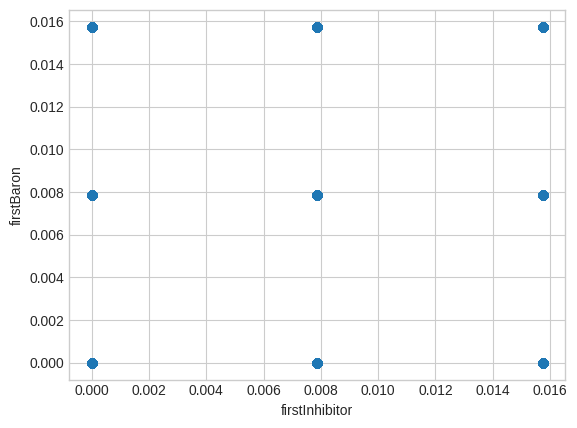

In [ ]:
plt.scatter(x['firstInhibitor'],x['firstBaron'])
plt.xlabel('firstInhibitor')
plt.ylabel('firstBaron')
plt.show()

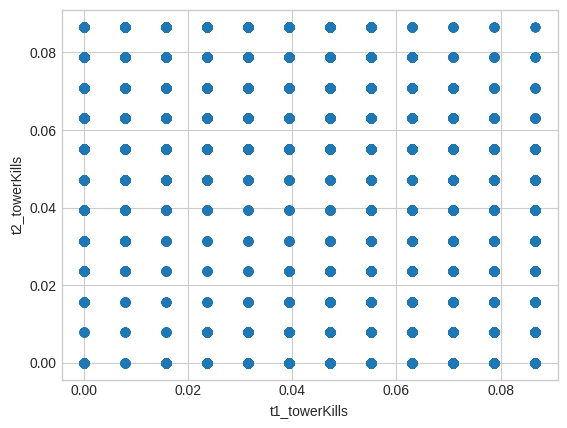

In [ ]:
plt.scatter(x['t1_towerKills'],x['t2_towerKills'])
plt.xlabel('t1_towerKills')
plt.ylabel('t2_towerKills')
plt.show()

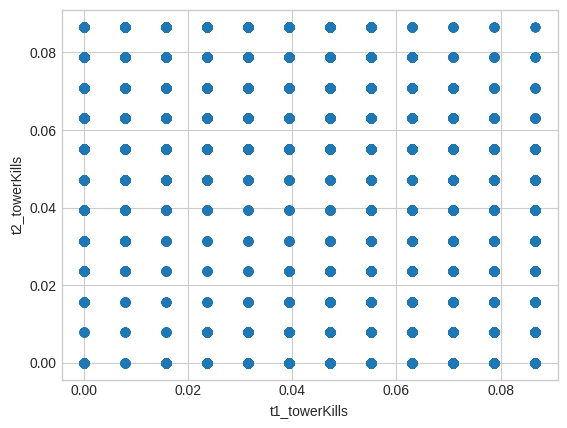

In [ ]:
plt.scatter(x['t1_towerKills'],x['t2_towerKills'])
plt.xlabel('t1_towerKills')
plt.ylabel('t2_towerKills')
plt.show()

In [ ]:
x.columns

Index(['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2',
       't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3_sum1', 't2_champ3_sum2',
       't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills', 't1_total_kills', 't2_total_kills'],
      dtype='object')

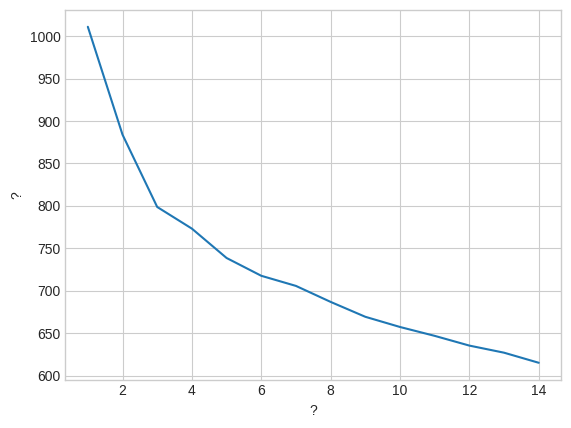

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,15):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x.drop(['t1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2'],axis = 1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.xlabel("?")
plt.ylabel("?")
plt.show()

In [ ]:
kmeans2 = KMeans(n_clusters = 2)
clusters = kmeans2.fit_predict(x)
x["label"] = clusters

In [ ]:
x.label.head(20)

,label
0,1
1,0
2,1
3,1
4,1
5,1
6,0
7,1
8,0
9,1


## Hierarchical Clustering (HC)

Text(0, 0.5, 'Distance')

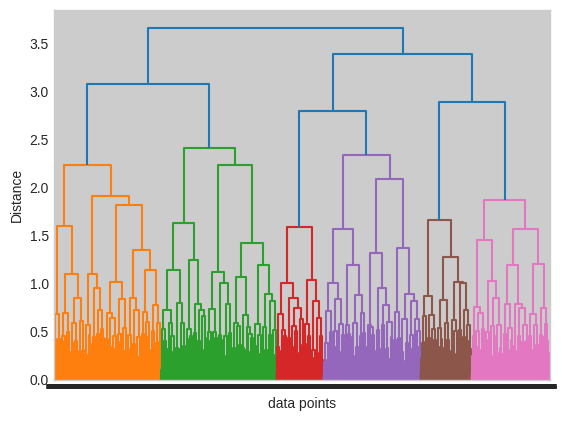

In [ ]:
from scipy.cluster.hierarchy import linkage,dendrogram
merg = linkage(x_test.drop(['t1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2',"t1_total_kills","t2_total_kills"],axis = 1),method = "ward")
dendrogram(merg,leaf_rotation = 0)
plt.xlabel("data points")
plt.ylabel("Distance")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 2,linkage = "ward")
cluster = hierarchical_cluster.fit_predict(x_test.drop(['t1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2',"t1_total_kills","t2_total_kills"],axis = 1))
x_test["label"] = cluster

In [ ]:
x_test.label.head(20)

,label
20983,0
48251,0
12038,1
23292,1
47896,1
38898,1
26229,0
37124,1
10506,0
32957,1


In [ ]:
!pip install torch


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and labels
X = data_game.drop(['winner'], axis=1)
y = data_game['winner'].values - 1  # Adjust labels to start from 0

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


class GameDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Create datasets
train_dataset = GameDataset(X_train, y_train)
test_dataset = GameDataset(X_test, y_test)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


class TransformerClassifier(nn.Module):
    def __init__(
        self, input_dim, num_classes, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1
    ):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_feedforward, nhead=nhead, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.classifier = nn.Linear(dim_feedforward, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: batch_size x input_dim
        x = self.embedding(x)  # batch_size x dim_feedforward
        x = x.unsqueeze(1)  # batch_size x seq_len x dim_feedforward
        x = x.permute(1, 0, 2)  # seq_len x batch_size x dim_feedforward
        x = self.transformer_encoder(x)  # seq_len x batch_size x dim_feedforward
        x = x.mean(dim=0)  # batch_size x dim_feedforward
        x = self.dropout(x)
        out = self.classifier(x)  # batch_size x num_classes
        return out


input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = TransformerClassifier(input_dim=input_dim, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_accuracy = correct / total
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {train_accuracy*100:.2f}%'
    )


model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy*100:.2f}%')



Epoch [1/10], Loss: 69.7989, Accuracy: 95.34%
Epoch [2/10], Loss: 56.1931, Accuracy: 96.14%
Epoch [3/10], Loss: 51.6135, Accuracy: 96.33%
Epoch [4/10], Loss: 49.9149, Accuracy: 96.48%
Epoch [5/10], Loss: 49.6264, Accuracy: 96.52%
Epoch [6/10], Loss: 48.2790, Accuracy: 96.53%
Epoch [7/10], Loss: 48.3921, Accuracy: 96.48%
Epoch [8/10], Loss: 47.0987, Accuracy: 96.55%
Epoch [9/10], Loss: 50.1144, Accuracy: 96.45%
Epoch [10/10], Loss: 46.1600, Accuracy: 96.72%
Test Accuracy: 96.51%


In [ ]:
!pip install shap
import shap

 98%|===================| 394/400 [00:33<00:00]       

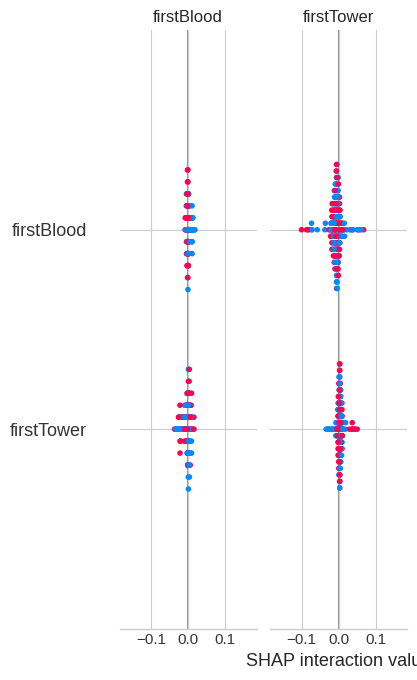

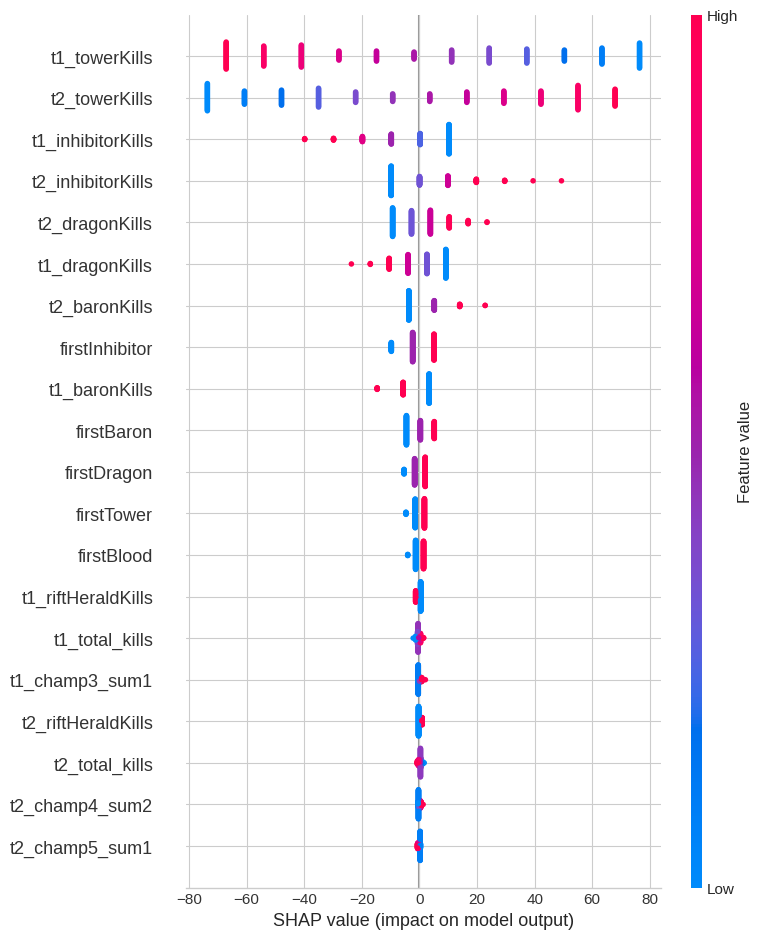

In [ ]:
# Compute SHAP values for Random Forest using approximate method
# Compute SHAP values for Random Forest
# Compute SHAP values for Random Forest using approximate method
# Compute SHAP values for Random Forest using approximate method
X_shap = X_test[:200]  # Use a smaller subset
X_train = x_train
y_test_shap = y_test[:200]
# Create the TreeExplainer without 'feature_perturbation'
explainer_rf = shap.Explainer(rf, x_train)

# Compute SHAP values
shap_values_rf = explainer_rf(X_shap)

# Plot summary plot
shap.summary_plot(shap_values_rf, X_shap, feature_names=X.columns)


# Compute SHAP values for Logistic Regression using a subset
explainer_lr = shap.Explainer(lr, X_train)
shap_values_lr = explainer_lr(X_shap)
shap.summary_plot(shap_values_lr, X_shap, feature_names=X.columns)




Shape of shap_values_to_plot: (10, 38, 2)
Shape of test_samples_np: (10, 38)
SHAP values for the first test sample:
[[ 3.04894529e-04 -3.04894529e-04]
 [ 7.32629994e-04 -7.32629992e-04]
 [ 6.98766555e-03 -6.98766551e-03]
 [-4.92196672e-05  4.92196700e-05]
 [ 9.21658920e-05 -9.21658929e-05]
 [-4.14954178e-04  4.14954166e-04]
 [ 1.34251281e-03 -1.34251281e-03]
 [ 4.79024806e-04 -4.79024765e-04]
 [-6.04839685e-04  6.04839685e-04]
 [ 5.70462684e-04 -5.70462710e-04]
 [ 2.73439718e-04 -2.73439726e-04]
 [-2.32601631e-04  2.32601616e-04]
 [ 1.82342074e-05 -1.82342164e-05]
 [-5.15962580e-04  5.15962607e-04]
 [ 9.82330380e-04 -9.82330388e-04]
 [-2.97409292e-04  2.97409285e-04]
 [-1.78161434e-02  1.78161435e-02]
 [-3.23521148e-03  3.23521148e-03]
 [-6.01141241e-04  6.01141236e-04]
 [ 5.24656491e-05 -5.24656451e-05]
 [ 1.27198802e-04 -1.27198801e-04]
 [ 9.19719084e-05 -9.19719110e-05]
 [-8.69125967e-04  8.69125910e-04]
 [-7.71205848e-04  7.71205869e-04]
 [ 1.15099735e-03 -1.15099736e-03]
 [-2.0774

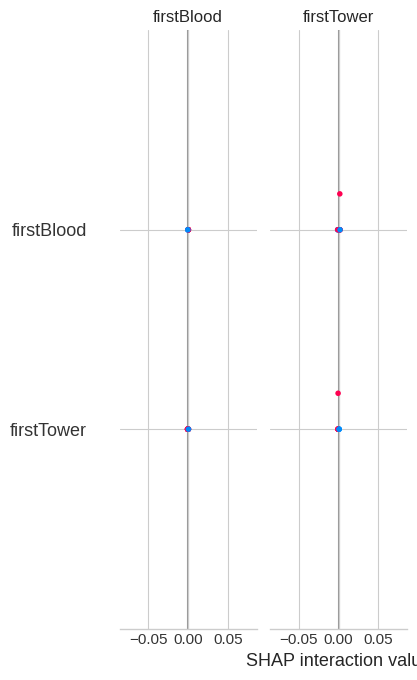

In [ ]:
shap.initjs()
model.eval()

# Define the wrapper model
class WrapperModel(nn.Module):
    def __init__(self, model):
        super(WrapperModel, self).__init__()
        self.model = model

    def forward(self, x):
        logits = self.model(x)
        probs = nn.functional.softmax(logits, dim=1)
        return probs  # Return probabilities for all classes

# Instantiate the wrapper model
wrapper_model = WrapperModel(model)
wrapper_model.eval()

# Prepare background and test samples
background = torch.tensor(X_train[:50].values, dtype=torch.float32)
test_samples = torch.tensor(X_train[:10].values, dtype=torch.float32)

# Create the SHAP explainer with check_additivity=False
explainer_trans = shap.GradientExplainer(wrapper_model, background)

# Compute SHAP values
shap_values_trans = explainer_trans.shap_values(test_samples)

# Convert test samples to NumPy for plotting
test_samples_np = test_samples.detach().numpy()

# If shap_values_trans is a list, select the desired class
if isinstance(shap_values_trans, list):
    # For binary classification, choose class 1
    shap_values_to_plot = shap_values_trans[1]
else:
    shap_values_to_plot = shap_values_trans

# Print shapes
print("Shape of shap_values_to_plot:", shap_values_to_plot.shape)
print("Shape of test_samples_np:", test_samples_np.shape)

# Print SHAP values for the first instance
print("SHAP values for the first test sample:")
print(shap_values_to_plot[0])  # First instance
# Create KernelExplainer for wrapper model



shap.summary_plot(shap_values_to_plot, test_samples_np, feature_names=X.columns)
# Compute the model's output for the background samples
# Compute the model's output for the background samples
# Compute the model's output for the background samples
# Compute the model's output for the background samples
# Extract SHAP values for class 1 (positive class)
shap_values_class_1 = shap_values_to_plot[:, :, 1]  # Shape: (10, 38)

# Reshape the first test sample to 2D (1 row, N columns)
test_sample_reshaped = test_samples_np[0].reshape(1, -1)

# Use the SHAP values for class 1 and plot for the first instance
shap.force_plot(expected_value[1], shap_values_class_1[0], test_sample_reshaped[0], feature_names=X.columns)




